In [1]:
from transformers import AutoTokenizer, AutoConfig
from ebany_research.llm_lora.changed_mistral import MistralForCausalLM
from datasets import load_dataset
import torch


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model_name = "Open-Orca/Mistral-7B-OpenOrca"
config = AutoConfig.from_pretrained(model_name)
device = 3
model = MistralForCausalLM.from_pretrained(model_name, device_map={"": device})
model = model.eval()
model = model.half()
print(count_parameters(model))
# model = MistralForCausalLM.from_pretrained(
#     model_name,
# )
# model = MistralForCausalLM._from_config(config=config)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
dataset = load_dataset("openaccess-ai-collective/oo-gpt4-filtered")
dataset = dataset["train"].to_list()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:38<00:00, 19.49s/it]


7241748480


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/user-name-goes-here/.local/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [2]:
dataset["train"][4]

{'id': 'cot.86217',
 'system_prompt': 'You are an AI assistant that helps people find information.',
 'question': "James runs a TV show and there are 5 main characters and 4 minor characters. He pays the minor characters $15,000 each episode. He paid the major characters three times as much. How much does he pay per episode? Let's be accurate as possible.",
 'response': 'James pays the minor characters $15,000 each episode. Since there are 4 minor characters, he pays them a total of 4 * $15,000 = $60,000 per episode.\n\nThe major characters are paid three times as much. So, each major character gets paid 3 * $15,000 = $45,000 per episode.\n\nThere are 5 main characters, so he pays them a total of 5 * $45,000 = $225,000 per episode.\n\nIn total, James pays $225,000 (major characters) + $60,000 (minor characters) = $285,000 per episode.',
 '__index_level_0__': 4}

In [2]:
import torch


dataset_id = 4


chat = [
    {"role": "system", "content": dataset[dataset_id]["system_prompt"]},
    {"role": "user", "content": dataset[dataset_id]["question"]},
]
inputs = tokenizer.apply_chat_template(
    chat, tokenize=True, add_generation_prompt=True, return_tensors="pt"
).to(model.device)


inputs = {
    "input_ids": inputs,
}
# inputs = tokenizer([text], return_tensors="pt").to(model.device)
max_layer = 32

with torch.no_grad():
    model(**inputs, return_dict=True, max_layer=max_layer)

    meta = model.model.layers[0].mlp.metadata

    diff = meta["gate_proj(x)"] - meta["x"] @ meta["gate_proj.weight"].T


diff.sum()

tensor(0., device='cuda:3', dtype=torch.float16)

In [4]:
meta = model.model.layers[0].mlp.metadata

In [5]:
meta["gate_proj.weight"].shape, meta["x"].shape

(torch.Size([14336, 4096]), torch.Size([1, 82, 4096]))

In [6]:
meta["x"] @ meta["gate_proj.weight"].T

tensor([[[-0.0654,  0.0341, -0.1154,  ..., -0.0035, -0.0227, -0.0404],
         [-0.0159,  0.0358,  0.0111,  ..., -0.0369, -0.2202, -0.0027],
         [-0.0570, -0.0512, -0.0150,  ...,  0.0484, -0.1598, -0.0205],
         ...,
         [-0.0699,  0.0356, -0.0950,  ..., -0.0266,  0.0304, -0.0388],
         [ 0.0313, -0.0826, -0.0411,  ..., -0.0871, -0.0525, -0.1994],
         [-0.0584, -0.0962,  0.0232,  ...,  0.0649,  0.0434, -0.0825]]],
       device='cuda:3')

In [ ]:
from torch.nn.parameter import Parameter


class LinearLora(torch.nn.Module):
    def __init__(self, in_dim=768, out_dim=768, r=16, bias=False):
        super().__init__()

        self.dense_h_to_4h = torch.nn.Linear(in_dim, r, bias=bias)

        self.dense_4h_to_h = torch.nn.Linear(r, out_dim, bias=bias)

    def forward(self, hidden_states):
        hidden_states = self.dense_h_to_4h(hidden_states)

        hidden_states = self.dense_4h_to_h(hidden_states)
        return hidden_states


class LinearLoraSVD(torch.nn.Module):
    def __init__(self, in_dim=768, out_dim=768, r=16, bias=False):
        super().__init__()

        self.dense_h_to_4h = torch.nn.Linear(in_dim, r, bias=bias)

        self.square = torch.nn.Linear(r, r, bias=bias)

        self.dense_4h_to_h = torch.nn.Linear(r, out_dim, bias=bias)

    def forward(self, hidden_states):
        hidden_states = self.dense_h_to_4h(hidden_states)

        hidden_states = self.square(hidden_states)

        hidden_states = self.dense_4h_to_h(hidden_states)
        return hidden_states


class NonLinearLora(torch.nn.Module):
    def __init__(self, in_dim=768, out_dim=768, r=8, bias=True):
        super().__init__()
        self.dense_h_to_4h = torch.nn.Linear(in_dim, r, bias=bias)
        self.act = torch.nn.GELU()
        self.dense_4h_to_h = torch.nn.Linear(r, out_dim, bias=bias)

    def forward(self, hidden_states):
        hidden_states = self.dense_h_to_4h(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dense_4h_to_h(hidden_states)
        return hidden_states


class Lora(torch.nn.Module):
    def __init__(
        self,
        in_dim=768,
        out_dim=768,
        r=8,
        bias=True,
    ):
        super().__init__()

        self.A = Parameter(
            torch.empty(
                (in_dim, r),
            ),
            requires_grad=True,
        )
        self.B = Parameter(
            torch.empty(
                (r, out_dim),
            ),
            requires_grad=True,
        )
        self.B.data.normal_(mean=0.0, std=0.02)
        self.A.data.normal_(mean=0.0, std=0.02)
        self.lora = LinearLora(
            in_dim=in_dim,
            out_dim=out_dim,
            r=r,
            bias=True,
        )
        self.lora2 = LinearLora(
            in_dim=in_dim,
            out_dim=out_dim,
            r=r,
            bias=True,
        )

    def forward(self, hidden_states):
        hidden_states = hidden_states @ (self.A @ self.B) + self.lora(hidden_states)
        # hidden_states = self.lora(hidden_states) + self.lora2(hidden_states)
        return hidden_states


# lora_model = LinearLoraSVD(
#     in_dim=config.hidden_size,
#     out_dim=config.intermediate_size,
#     r=64*2,
#     bias=True,
# )
# lora_model = NonLinearLora(
#     in_dim=config.hidden_size,
#     out_dim=config.intermediate_size,
#     r=64*2*2,


#     bias=True,


# )


mse_loss = torch.nn.MSELoss(reduction="sum")


amount_epochs = 10000


for layer_pos in range(max_layer):
    meta = model.model.layers[layer_pos].mlp.metadata
    # lora_model = LinearLora(
    #     in_dim=config.hidden_size,
    #     out_dim=config.intermediate_size,
    #     r=16,
    #     bias=True,
    # )
    lora_model = Lora(
        in_dim=config.hidden_size,
        out_dim=config.intermediate_size,
        r=64,
        bias=True,
    )
    lora_model.to(model.device)
    optimizer = torch.optim.Adam(lora_model.parameters(), lr=0.001)

    for step in range(amount_epochs):
        optimizer.zero_grad()

        lora_result = lora_model(meta["x"])
        labels = torch.vstack([meta["gate_proj(x)"]])

        predicts = torch.vstack([lora_result])
        loss = mse_loss(
            predicts,
            labels,
        )

        loss.backward()
        optimizer.step()
    print(f"Layer {layer_pos} Step: {step} - {loss.item()}")

In [ ]:
original_params = config.hidden_size * config.intermediate_size
new_params = (config.hidden_size * 64 + 64 * config.intermediate_size) * 2

print(original_params)
print(new_params)
print(original_params / new_params)

In [34]:
U, S, V = torch.svd_lowrank(meta["gate_proj.weight"], q=64, niter=1000, M=None)

In [ ]:
U.shape, S.shape, V.shape, meta["gate_proj.weight"].shape

In [38]:
(U @ torch.diag(S) @ V.T).shape

torch.Size([14336, 4096])

In [39]:
(U @ torch.diag(S) @ V.T - meta["gate_proj.weight"]).sum()

tensor(-26.6719, device='cuda:3')

In [ ]:
meta["x"]

In [ ]:
meta["x"] @ (U @ torch.diag(S) @ V.T).T

In [46]:
mse_loss(
    meta["x"] @ ((U @ torch.diag(S) @ V.T).T),
    meta["gate_proj(x)"],
)

tensor(540050.2500, device='cuda:3')

### Train on bigger dataset

In [7]:
# from torch.utils.data import Dataset, DataLoader
# from transformers import DataCollatorWithPadding


# class OpenOrcaDataset(Dataset):
#     def __init__(
#         self,
#         dataset=None,
#         device="cuda:3",
#         tokenizer=None,
#     ):
#         self.dataset = dataset
#         self.tokenizer = tokenizer
#         self.device = device

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         dataset_item = self.dataset[idx]
#         chat = [
#             {"role": "system", "content": dataset_item["system_prompt"]},
#             {"role": "user", "content": dataset_item["question"]},
#         ]
#         inputs = self.tokenizer.apply_chat_template(
#             chat,
#             tokenize=False,
#             add_generation_prompt=True,
#         )
#         inputs = self.tokenizer(
#             inputs,
#             return_tensors="pt",
#         ).to(self.device)
#         for key in inputs.keys():
#             inputs[key] = inputs[key].squeeze(0)
#         # print(inputs['input_ids'].shape)
#         return inputs


# train_dataset = OpenOrcaDataset(
#     dataset=dataset["train"],
#     device=model.device,
#     tokenizer=tokenizer,
# )

# pad_datacollator = DataCollatorWithPadding(
#     tokenizer=tokenizer,
#     padding=True,
# )

# train_dataloader = DataLoader(
#     dataset=train_dataset,
#     batch_size=1,
#     collate_fn=pad_datacollator,
# )
# next(iter(train_dataloader))
# # train_dataset[0]

In [3]:
import tqdm


dataset_size = 200
max_layer = 16

new_dataset = []

for dataset_id in tqdm.tqdm(range(dataset_size)):
    chat = [
        {"role": "system", "content": dataset[dataset_id]["system_prompt"]},
        {"role": "user", "content": dataset[dataset_id]["question"]},
    ]
    inputs = tokenizer.apply_chat_template(
        chat,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        # padding="max_length",
        # max_length=4096,
    ).to(model.device)

    inputs = {
        "input_ids": inputs,
    }
    with torch.no_grad():
        model(**inputs, return_dict=True, max_layer=max_layer)

    for layer_pos in range(max_layer):
        meta = model.model.layers[layer_pos].mlp.metadata
        new_meta = {}
        if layer_pos == max_layer - 1:
            for key in meta.keys():
                new_meta[key] = meta[key].to("cpu").clone()
            dataset[dataset_id][layer_pos] = new_meta
        del model.model.layers[layer_pos].mlp.metadata
    # print(dataset[dataset_id][0]['x'].shape)
    # break

    new_dataset.append(dataset[dataset_id])
    # break

100%|██████████| 200/200 [00:22<00:00,  8.91it/s]


In [6]:
new_dataset[1][layer_pos]["x"].shape

torch.Size([1, 90, 4096])

In [7]:
# EXTREMELLY LARGE AND LONG
# dataset_name = "./ebany_research/llm_lora/openorca_train_tensors_layer_0.pt"
dataset_name = f"./ebany_research/llm_lora/openorca_train_tensors_layer_{layer_pos}.pt"
torch.save(new_dataset, dataset_name)

#### free gpu memory

In [8]:
import gc

model = model.cpu()
gc.collect()
torch.cuda.empty_cache()

In [9]:
import torch

new_dataset = torch.load(dataset_name)

In [11]:
new_dataset[0][layer_pos]["gate_proj(x)"]

tensor([[[ 0.0405, -1.0215,  0.2246,  ..., -0.0882, -1.3809, -0.0951],
         [ 0.3958, -1.0752,  0.9307,  ..., -0.3438, -0.7207, -0.5972],
         [-0.0451,  0.1144, -0.0617,  ...,  0.0320,  0.0298,  0.0069],
         ...,
         [ 0.1104, -0.7886, -0.5244,  ..., -0.5146, -0.3328, -1.0049],
         [-0.1449, -0.4019,  0.2666,  ..., -0.2749, -0.7480, -0.5869],
         [ 0.1627, -0.3955,  0.8164,  ..., -0.8057,  0.8018, -0.9912]]],
       dtype=torch.float16)

In [3]:
new_dataset[0][0]["gate_proj(x)"].shape

torch.Size([1, 4096, 14336])

In [13]:
from torch.utils.data import Dataset, DataLoader


class TensorsOpenOrcaDataset(Dataset):
    def __init__(self, dataset=None, device="cuda:3", layer: int = 0):
        self.dataset = dataset
        self.device = device
        self.layer = layer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        dataset_item = self.dataset[idx]
        inputs = dataset_item[self.layer]

        # for key in inputs.keys():
        #     inputs[key] = inputs[key].squeeze(0)

        return inputs


train_tensor_dataset = TensorsOpenOrcaDataset(
    dataset=new_dataset[:100], layer=layer_pos
)
valid_tensor_dataset = TensorsOpenOrcaDataset(
    dataset=new_dataset[100:], layer=layer_pos
)
train_tensor_dataloader = DataLoader(dataset=train_tensor_dataset, batch_size=1)
test_tensor_dataloader = DataLoader(dataset=valid_tensor_dataset, batch_size=1)
next(iter(valid_tensor_dataset))

{'x': tensor([[[ 2.3718e-01,  5.1094e+00,  1.5576e-01,  ..., -1.5674e+00,
            1.3904e-01, -3.6670e-01],
          [ 7.3926e-01,  2.5039e+00,  2.8047e+00,  ..., -1.6943e+00,
           -5.0928e-01, -5.3027e-01],
          [-1.5335e-02, -2.6660e-01,  1.2817e-01,  ...,  1.1652e-01,
            3.5934e-03,  4.9019e-03],
          ...,
          [ 1.0332e+00,  2.0879e+00, -1.1895e+00,  ..., -1.1006e+00,
           -1.7881e+00, -1.8613e+00],
          [ 6.5039e-01,  2.7402e+00,  1.9951e+00,  ...,  8.7988e-01,
           -2.3887e+00,  4.4067e-01],
          [-2.3672e+00,  5.0508e+00, -1.0488e+00,  ...,  1.0723e+00,
           -5.6299e-01,  7.3242e-01]]], dtype=torch.float16),
 'gate_proj(x)': tensor([[[ 0.0397, -1.0205,  0.2244,  ..., -0.0872, -1.3809, -0.0957],
          [ 0.3972, -1.0752,  0.9297,  ..., -0.3442, -0.7192, -0.5991],
          [-0.0451,  0.1144, -0.0617,  ...,  0.0320,  0.0298,  0.0069],
          ...,
          [-0.6221, -0.2135,  0.0919,  ..., -0.2054, -0.2878, -0.22

1190

In [10]:
torch.tensor([1]).clone()

tensor([1])

In [95]:
from torch.nn.parameter import Parameter
from ebany_research.llm_lora.changed_neox import LinearLora



class NonLinearLora(torch.nn.Module):


    def __init__(self, in_dim=768, out_dim=768, r=8, bias=True):

        super().__init__()

        self.dense_h_to_4h = torch.nn.Linear(in_dim, r, bias=bias)


        self.act = torch.nn.GELU()

        self.dense_4h_to_h = torch.nn.Linear(r, out_dim, bias=bias)


    def forward(self, hidden_states):

        hidden_states = self.dense_h_to_4h(hidden_states)
        hidden_states = self.act(hidden_states)


        hidden_states = self.dense_4h_to_h(hidden_states)

        return hidden_states



class Lora(torch.nn.Module):
    def __init__(
        self,

        in_dim=768,
        out_dim=768,
        r=8,
        bias=True,
    ):

        super().__init__()


        self.A = Parameter(torch.empty((in_dim, r)), requires_grad=True)

        self.B = Parameter(torch.empty((r, out_dim)), requires_grad=True)


        self.A1 = Parameter(torch.empty((in_dim, r)), requires_grad=True)

        self.B1 = Parameter(torch.empty((r, out_dim)), requires_grad=True)


        self.A.data.normal_(mean=0.0, std=0.02)

        self.B.data.normal_(mean=0.0, std=0.02)


        self.lora = LinearLora(
            in_dim=in_dim,
            out_dim=out_dim,
            r=r,

            bias=True,
        )


        self.lora2 = LinearLora(
            in_dim=in_dim,
            out_dim=out_dim,
            r=r,

            bias=True,
        )


    def forward(self, hidden_states):

        hidden_states = hidden_states @ (self.A @ self.B) + self.lora(hidden_states)

        # hidden_states = self.lora(hidden_states) + self.lora2(hidden_states)

        return hidden_states


class LoraSVD(torch.nn.Module):
    def __init__(
        self,
        in_dim=768,
        out_dim=768,
        r=8,
        bias=True,
    ):
        super().__init__()

        self.U = Parameter(torch.empty((out_dim, r)), requires_grad=True)
        # self.U = Parameter(torch.empty((in_dim, r)), requires_grad=False)
        # self.U_i = Parameter(torch.empty((out_dim, r)), requires_grad=True)

        self.D = Parameter(torch.empty((r, r)), requires_grad=True)
        # self.D = Parameter(torch.empty((r, r)), requires_grad=False)
        # self.D_i = Parameter(torch.empty((r, r)), requires_grad=True)

        self.V = Parameter(torch.empty((r, in_dim)), requires_grad=True)
        # self.V = Parameter(torch.empty((r, out_dim)), requires_grad=False)
        # self.V_i = Parameter(torch.empty((r, in_dim)), requires_grad=True)

        # self.U.data.normal_(mean=0.0, std=0.02)
        # self.D.data.normal_(mean=0.0, std=0.02)
        # self.V.data.normal_(mean=0.0, std=0.02)
        # self.lora = LinearLora(
        #     in_dim=in_dim,
        #     out_dim=out_dim,
        #     r=64,

        #     bias=True,
        # )

    def forward(self, hidden_states):
        # hidden_states = hidden_states @ (self.A @ self.B) + self.lora(hidden_states)
        # hidden_states = (
        #     hidden_states
        #     @ (
        #         ((self.U + self.U_i) / 2)
        #         @ ((self.D + self.D_i) / 2)
        #         @ ((self.V + self.V_i) / 2)
        #     ).T
        # )
        hidden_states = hidden_states @ (self.U @ self.D @ self.V).T 
        # hidden_states = self.lora(hidden_states) + self.lora2(hidden_states)
        return hidden_states



mse_loss = torch.nn.MSELoss(reduction="mean")



amount_epochs = 100



# epoch 306 min train loss  922.

r = 16
lora_model = LoraSVD(
    in_dim=config.hidden_size,
    out_dim=config.intermediate_size,
    r=r,
    bias=True,
)
# lora_model = Lora(
#     in_dim=config.hidden_size,
#     out_dim=config.intermediate_size,
#     r=r,
#     bias=True,


# )

U, S, Vh = torch.linalg.svd(
    new_dataset[0][layer_pos]["gate_proj.weight"].to(torch.float32),
    full_matrices=False,
)
# U[:, : r + 1] @ torch.diag(S[: (r + 1)]) @ Vh[: r + 1, :]
lora_model.U.data = U[:, :r]
lora_model.D.data = torch.diag(S[:r])
lora_model.V.data = Vh[:r, :]
# lora_model.U_i.data = U[:, :r]
# lora_model.D_i.data = torch.diag(S[:r])
# lora_model.V_i.data = Vh[:r, :]


lora_model.to(device)


lora_model.to(torch.float32)


optimizer = torch.optim.Adam(lora_model.parameters(), lr=0.0000001)


for epoch in range(amount_epochs):
    train_total_loss = 0
    lora_model.train()


    for batch_id, batch in enumerate(train_tensor_dataset):
        optimizer.zero_grad()

        x = batch["x"].to(device)
        x = x.to(torch.float32)
        predicts = lora_model(x)
        labels = batch["gate_proj(x)"].to(device)
        labels = labels.to(torch.float32)
        loss = mse_loss(

            predicts,
            labels,
        )


        train_total_loss += loss.item()

        loss.backward()

        # torch.nn.utils.clip_grad_norm_(
        #     lora_model.parameters(),
        #     1.0,
        # )


        if (batch_id + 1) % 30:

            optimizer.step()
        # break
    # if epoch % 100 == 0:

    print(f"Epoch: {epoch} - train loss {train_total_loss / len(train_tensor_dataset)}")
    lora_model.eval()
    valid_total_loss = 0

    with torch.no_grad():

        for batch_id, batch in enumerate(valid_tensor_dataset):

            x = batch["x"].to(device)
            x = x.to(torch.float32)
            predicts = lora_model(x)
            labels = batch["gate_proj(x)"].to(device)
            labels = labels.to(torch.float32)
            loss = mse_loss(
                predicts,
                labels,
            )


            valid_total_loss += loss.item()


        # break


    # if epoch % 100 == 0:

    print(f"Epoch: {epoch} - valid loss {valid_total_loss / len(valid_tensor_dataset)}")


    print("---")

    # break


# break

Epoch: 0 - train loss 0.2828603911399841
Epoch: 0 - valid loss 0.27942157581448557
---
Epoch: 1 - train loss 0.28285539388656616
Epoch: 1 - valid loss 0.27941677197813986
---
Epoch: 2 - train loss 0.28285050302743914
Epoch: 2 - valid loss 0.27941204637289047
---
Epoch: 3 - train loss 0.2828456810116768
Epoch: 3 - valid loss 0.27940738782286645
---
Epoch: 4 - train loss 0.28284092277288436
Epoch: 4 - valid loss 0.2794027841091156
---
Epoch: 5 - train loss 0.2828362140059471
Epoch: 5 - valid loss 0.2793982243537903
---
Epoch: 6 - train loss 0.28283155769109725
Epoch: 6 - valid loss 0.27939370334148406
---
Epoch: 7 - train loss 0.2828269371390343
Epoch: 7 - valid loss 0.2793892207741737
---
Epoch: 8 - train loss 0.2828223451972008
Epoch: 8 - valid loss 0.27938476458191874
---
Epoch: 9 - train loss 0.2828177839517593
Epoch: 9 - valid loss 0.2793803270161152
---
Epoch: 10 - train loss 0.2828132367134094
Epoch: 10 - valid loss 0.27937590509653093
---
Epoch: 11 - train loss 0.2828087037801742

KeyboardInterrupt: 

In [80]:
S.numpy()

array([2.592468  , 1.1172432 , 1.0889344 , ..., 0.09039976, 0.08639444,
       0.08478527], dtype=float32)

In [81]:
torch.arange(0,S.shape[0]).numpy()

array([   0,    1,    2, ..., 4093, 4094, 4095])

In [97]:
U, S, Vh = torch.linalg.svd(
    new_dataset[0][layer_pos]["x"].to(torch.float32),
    full_matrices=False,
)

S[0]**2 / (S**2).sum()

tensor([0.1991, 0.0465, 0.0390, 0.0309, 0.0294, 0.0242, 0.0188, 0.0184, 0.0179,
        0.0168, 0.0162, 0.0153, 0.0140, 0.0133, 0.0129, 0.0114, 0.0113, 0.0108,
        0.0106, 0.0099, 0.0093, 0.0091, 0.0088, 0.0086, 0.0084, 0.0082, 0.0079,
        0.0076, 0.0073, 0.0073, 0.0070, 0.0067, 0.0066, 0.0065, 0.0063, 0.0061,
        0.0059, 0.0058, 0.0056, 0.0055, 0.0055, 0.0054, 0.0053, 0.0052, 0.0050,
        0.0049, 0.0047, 0.0046, 0.0044, 0.0044, 0.0043, 0.0042, 0.0042, 0.0041,
        0.0040, 0.0039, 0.0039, 0.0038, 0.0037, 0.0036, 0.0036, 0.0036, 0.0036,
        0.0034, 0.0033, 0.0033, 0.0033, 0.0032, 0.0031, 0.0031, 0.0030, 0.0030,
        0.0029, 0.0029, 0.0029, 0.0028, 0.0027, 0.0027, 0.0027, 0.0026, 0.0026,
        0.0026, 0.0026, 0.0025, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0023,
        0.0023, 0.0023, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0017, 0.0017, 

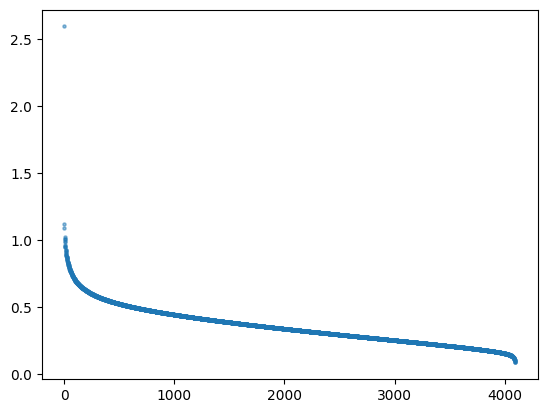

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)



area = 5 # 0 to 15 point radii

plt.scatter(torch.arange(0,S.shape[0]).numpy(), S.numpy(), s=area, alpha=0.5)
plt.show()

In [60]:
new_dataset[0][layer_pos]["gate_proj.weight"].shape

torch.Size([14336, 4096])

In [53]:
U, S, Vh = torch.linalg.svd(
    new_dataset[0][layer_pos]["gate_proj.weight"].to(torch.float32),
    full_matrices=False,
)
U.shape, S.shape, Vh.shape

(torch.Size([14336, 4096]), torch.Size([4096]), torch.Size([4096, 4096]))

In [56]:
lora_model.V.data.shape, lora_model.D.data.shape, lora_model.V.data.shape

(torch.Size([64, 4096]), torch.Size([64, 64]), torch.Size([64, 4096]))

### truncated svd, max singular

In [54]:
from torch.nn.parameter import Parameter
import math
import random
from ebany_research.llm_lora.changed_neox import LinearLora


class LoraSVD(torch.nn.Module):
    def __init__(
        self,
        in_dim=768,
        out_dim=768,
        r=8,
        bias=True,
    ):
        super().__init__()

        self.U = Parameter(torch.empty((in_dim, r)), requires_grad=False)
        self.U_i = Parameter(torch.empty((in_dim, r)), requires_grad=True)

        self.D = Parameter(torch.empty((r, r)), requires_grad=False)
        self.D_i = Parameter(torch.empty((r, r)), requires_grad=True)

        self.V = Parameter(torch.empty((r, out_dim)), requires_grad=False)
        self.V_i = Parameter(torch.empty((r, out_dim)), requires_grad=True)

        self.lora = LinearLora(
            in_dim=in_dim,
            out_dim=out_dim,
            r=r,
            bias=True,
        )

    def forward(self, hidden_states):
        # hidden_states = hidden_states @ (self.A @ self.B) + self.lora(hidden_states)
        hidden_states = hidden_states @ (
            (self.U + self.U_i) @ (self.D + self.D_i) @ (self.V + self.V_i)
        )
        # hidden_states = self.lora(hidden_states) + self.lora2(hidden_states)
        return hidden_states


def low_rank_decomposition(
    weight,
    rank_ratio=0.1,
    parameter_ratio=0.15,
    remove_criteria="max_eigenvalue",
    rank=16,
    log_level="DEBUG",
    return_dict=True,
):
    """
    :param          weight: The matrix to decompose, of shape (H, W)
    :param      rank_ratio: rank_of_decomposed_matrix / rank_of_input_weight
    :param parameter_ratio: parameter_num_of_decomposed_matrix / (H * W). If specify, override rank_ratio
    :param remove_criteria: choose from ['max_eigenvalue', 'random', 'min_eigenvalue']
    :param       log_level: choose from ['IGNORE', 'INFO', 'DEBUG']
    :param     return_dict: Return a dict if True, else return a tuple (L, R)
    :return:
    """

    """parameter_ratio = rank * (H + W) / (H * W)"""
    """rank_ratio = """
    matrix_dimension = len(weight.size())
    assert matrix_dimension == 2, "Only Support 2D matrix"
    H, W = weight.size()

    # Use SVD to decompose a matrix, default full_matrices is False to save parameters
    U, S, Vh = torch.linalg.svd(weight, full_matrices=False)
    # rank = torch.count_nonzero(S)
    # is_full_rank = rank == min(H, W)

    # if parameter_ratio is not None:
    #     reduced_rank = math.ceil(parameter_ratio * (H * W) / (H + W))
    # else:
    #     reduced_rank = math.ceil(rank * rank_ratio)
    reduced_rank = rank
    if remove_criteria == "max_eigenvalue":
        L = U @ (torch.sqrt(torch.diag(S)[:, 0:reduced_rank]))
        R = torch.sqrt(torch.diag(S)[0:reduced_rank, :]) @ Vh
    elif remove_criteria == "random":
        selected_index = random.choices(range(len(S)), k=reduced_rank)
        L = U @ (torch.sqrt(torch.diag(S)[:, selected_index]))
        R = torch.sqrt(torch.diag(S)[selected_index, :]) @ Vh
    elif remove_criteria == "min_eigenvalue":
        len_s = len(S)
        L = U @ (torch.sqrt(torch.diag(S)[:, len_s - reduced_rank :]))
        R = torch.sqrt(torch.diag(S)[len_s - reduced_rank :, :]) @ Vh
    else:
        raise NameError("remove criteria not support")

    if log_level == "DEBUG":
        print(
            f"W: ({H},{W}) | Rank: {rank} | U:{U.shape} | S:{S.shape} | Vh:{Vh.shape}"
        )
        print(
            f"Reduced Rank: {reduced_rank} | Num Parameters: {(H + W) * reduced_rank}"
        )
        print(f"L: {L.shape} | R: {R.shape}")

    if return_dict:
        return {"L": L, "R": R, "U": U, "S": S, "Vh": Vh, "reduced_rank": reduced_rank}
    else:
        return L, R


mse_loss = torch.nn.MSELoss(reduction="sum")

lora_model = LoraSVD(
    in_dim=config.hidden_size,
    out_dim=config.intermediate_size,
    r=64,
    bias=True,
)
lora_model.to(device)
lora_model.to(torch.float32)

W: (14336,4096) | Rank: 16 | U:torch.Size([14336, 4096]) | S:torch.Size([4096]) | Vh:torch.Size([4096, 4096])
Reduced Rank: 16 | Num Parameters: 294912
L: torch.Size([14336, 16]) | R: torch.Size([16, 4096])
true_svd_difference=0.0003874329850077629
r=128 lowrank_svd_difference=564.4758911132812


In [16]:
original_weights = next(iter(valid_tensor_dataset))["gate_proj.weight"].to(device)
original_weights = original_weights.to(torch.float32)

In [17]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [18]:
U, S, Vh = torch.linalg.svd(original_weights, full_matrices=False)

In [32]:
N = original_weights.shape[0]
sigma = 0.32999
cutoff = 4 / 3 ** (0.5) * sigma
r = torch.where(S > cutoff)[0].max().item()
r = 64

57

In [35]:
mse_loss(
    U[:, : r + 1] @ torch.diag(S[: (r + 1)]) @ Vh[: r + 1, :],
    original

tensor([[ 3.6016e-04, -8.9347e-04, -8.6622e-04,  ..., -3.5067e-04,
          2.6375e-04, -3.7556e-04],
        [-4.4451e-04, -2.3259e-04,  9.5287e-05,  ..., -4.3446e-04,
          5.3174e-04,  1.6125e-03],
        [ 4.1949e-04,  1.8159e-03, -1.4118e-04,  ...,  2.5175e-04,
         -3.3946e-04, -6.7389e-04],
        ...,
        [ 1.9930e-04,  7.9790e-04, -9.0183e-04,  ..., -7.6730e-04,
          1.2988e-05,  8.4269e-04],
        [-7.9907e-05, -5.3753e-06,  1.6677e-04,  ..., -2.9642e-04,
         -4.5371e-05, -1.2702e-04],
        [ 2.2607e-04,  1.5306e-03,  5.6364e-04,  ...,  6.3548e-04,
         -3.3000e-05,  9.6451e-04]], device='cuda:3')

In [58]:
(U[:, : r + 1] @ torch.diag(S[: (r + 1)]) @ Vh[: r + 1, :]).shape

torch.Size([14336, 4096])

In [59]:
U[:, : r + 1].shape

torch.Size([14336, 1])

In [57]:
for r in range(S.shape[0]):
    truncated_matrix = U[:, : r + 1] @ torch.diag(S[: (r + 1)]) @ Vh[: r + 1, :]
    print(truncated_matrix.shape)

    diff = mse_loss(
        truncated_matrix,
        original_weights,
    )

    print(f"r={r} diff={diff}")

torch.Size([14336, 4096])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cpu!

In [33]:
S.tolist()

[2.5928566455841064,
 1.1174074411392212,
 1.0885881185531616,
 1.0183885097503662,
 1.0076931715011597,
 1.0032069683074951,
 0.9918707609176636,
 0.9808992147445679,
 0.9594203233718872,
 0.9559280276298523,
 0.9449878334999084,
 0.9441251754760742,
 0.9269037246704102,
 0.9261745810508728,
 0.9165115356445312,
 0.9123530983924866,
 0.9025701284408569,
 0.8972771167755127,
 0.8885034918785095,
 0.8872251510620117,
 0.8825976252555847,
 0.8756235241889954,
 0.8716121315956116,
 0.8686613440513611,
 0.8643426299095154,
 0.8598101735115051,
 0.8585602641105652,
 0.8547016382217407,
 0.8465468883514404,
 0.8428547978401184,
 0.8367452025413513,
 0.8339047431945801,
 0.8310821056365967,
 0.8297173380851746,
 0.8269672989845276,
 0.8246450424194336,
 0.8173280358314514,
 0.8153272271156311,
 0.8134797811508179,
 0.8118128180503845,
 0.8091875910758972,
 0.8035658597946167,
 0.8005534410476685,
 0.7975896000862122,
 0.7968849539756775,
 0.7944366931915283,
 0.7893564701080322,
 0.7858853340

In [85]:
U.shape, S.shape, Vh.shape

(torch.Size([14336, 4096]), torch.Size([4096]), torch.Size([4096, 4096]))

In [77]:
torch.where(S > cutoff)

(tensor([0, 1], device='cuda:3'),)

In [73]:
cutoff

1.7320508075688776

In [34]:
S.max()

tensor(2.5929, device='cuda:3')

### evaluate on data

In [44]:
valid_total_loss = 0
r = 3999
with torch.no_grad():
    for batch_id, batch in enumerate(valid_tensor_dataset):

        x = batch["x"].to(device)
        x = x.to(torch.float32)
        # predicts = lora_model(x)
        # predicts = x @ original_weights.T
        predicts = x @ (U[:, : r + 1] @ torch.diag(S[: (r + 1)]) @ Vh[: r + 1, :]).T
        labels = batch["gate_proj(x)"].to(device)
        labels = labels.to(torch.float32)

        loss = mse_loss(
            predicts,
            labels,
        )
        valid_total_loss += loss.item()

    # break
# if epoch % 100 == 0:
print(f"Epoch: {0} - valid loss {valid_total_loss / len(valid_tensor_dataset)}")

Epoch: 0 - valid loss 2010.396968383789
